In [1]:
from libraries import * 
from preprocessing import SubsetSC, Preprocessing
from utils import downsample, pad_sequence
warnings.filterwarnings("ignore")

# selecting GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on GPU = {str(device) == 'cuda'}")

# create training validation splits, see later for test
print(f"1. extracting subsets")
train_set = SubsetSC("training")
validation_set = SubsetSC("validation")
test_set = [] # SubsetSC("test")
print(f"   extraction done")

# performing downsampling for faster computation
downsampling = True
if downsampling:
    print(f"2. downsampling datasets")
    train_set = downsample(train_set)
    validation_set = downsample(validation_set)
    # test_set = downsample(test_set)
print(f"   downsampling done")
print(f"3. datasets ready")

# setting up computational parameters
if device == "cuda":
    num_workers, pin_memory = 4, True
else:
    num_workers, pin_memory = 0, False


    
# bunch of useful functions ************************
# **************************************************
    
# display the list of labels available in the dataset
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))    
    
    
def collate_fn(batch):
    """ 
    desc: turn audio's list batch into two batch tensors for model 
    """
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets


def index_to_label(index):
    """ 
    desc: return the word corresponding to the index in labels 
    """
    return labels[index]


# encoding each word using its index in the list of labels
def label_to_index(word):
    """ 
    desc: return the position of the word in labels 
    """
    return torch.tensor(labels.index(word))


# ****************************************
# ****************************************


# sets in to dataloaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
    num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
print(f"set up of dataloader done")

running on GPU = True
1. extracting subsets


  0%|          | 82/84843 [00:00<01:43, 818.60it/s]

   extraction done
2. downsampling datasets


100%|██████████| 9981/9981 [00:08<00:00, 1163.46it/s]

   downsampling done
3. datasets ready
set up of dataloader done


In [ ]:
validation_set

In [96]:
from preprocessing import Preprocessing
processor = Preprocessing(train_set, validation_set, test_set)
#
class CnnAudioNet(nn.Module):
    def __init__(self,NumClasses):
        super(CnnAudioNet,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.BN1 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(15808,128)
        self.fc2 = nn.Linear(128, self.NumClasses )

        
        
    def forward(self,x):
        print(x.shape)
       
        # print(self.C1(x)[0][0][0])
        # print(self.BN1(self.C1(x))[0][0][0]) returns nan
        
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.C1(x))
        print(x.shape)
        
        
        # flatten image input
        x = (x.view(-1,np.prod(x.shape[1:]))) # self.dropout
        print(x.shape)
        
        # add dropout layer
        x =  (self.fc1(x)) # self.dropout
        print(x.shape)
        # add 1st hidden layer, with relu activation function
        # add dropout layer
        # add 2nd hidden layer, with relu activation function
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        print(x.shape)
        return x
  
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.MultiLabelSoftMarginLoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.001)# specify optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.005)


def count_parameters(model):
    """ desc: return number of parameter in model """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



model = CnnAudioNet(len(labels))
model.to(device)  # convert initialized model to CUDA optimized model
print(model)
print(f"Number of parameters: {count_parameters(model)}")

model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx > 0:
        break
    print(data.squeeze())
    
    # move data to device (device = GPU if available)
    lmfs = processor.process_dataset(data.squeeze()) # bientot process batch
    lmfs = torch.from_numpy(np.array(lmfs)).to(device, dtype=torch.float)
    target = target.to(device)
    
    output = model(lmfs.unsqueeze(1))
    
    
    # negative log-likelihood for tensor of size (batch x 1 x n_output)
    loss = F.nll_loss(output, target)
    print(f"output.argmax(1)")
    print(output.argmax(1).shape)
    print(f"target.shape")
    print(target.shape)

    optimizer.zero_grad()  # explicitly set gradients to zero before starting backpropragation
    loss.backward()  # compute gradients
    optimizer.step()  # optimization step: update of parameters
    
    print(loss)
    
    

    


    


CnnAudioNet(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=15808, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
)
Number of parameters: 2028451
tensor([[-1.0375e-04, -4.0077e-04, -5.4308e-04,  ..., -1.6332e-04,
          2.0022e-04,  7.9851e-04],
        [ 1.1458e-05, -1.3454e-05, -8.4859e-07,  ..., -6.5344e-05,
         -4.0961e-05, -1.2225e-05],
        [-3.5273e-05,  2.9989e-05,  1.2140e-04,  ..., -8.2515e-05,
         -9.4482e-05, -8.6488e-05],
        ...,
        [-5.3392e-05, -8.1919e-05, -8.9945e-05,  ..., -1.0134e-04,
         -1.0786e-04, -1.3306e-04],
        [ 4.5527e-03,  7.7598e-03,  6.7922e-03,  ...,  1.7781e-03,
         -1.7893e-03, -5.2418e-03],
        [-9.5552e-06,  5.6219e-05,  4.4254e-05,  ...,  1.0691e-04,
          1.2373e-04, -1.4221e-04]])
torch.Size([256, 1, 38, 13])
torch.S

In [33]:
print(f"size of input batches {lmfs.shape}")

size of input batches torch.Size([256, 38, 13])


In [50]:
38*13*2

988

In [31]:
lmfs.shape

torch.Size([256, 38, 13])

In [30]:
lmfs.unsqueeze(1).shape

torch.Size([256, 1, 38, 13])

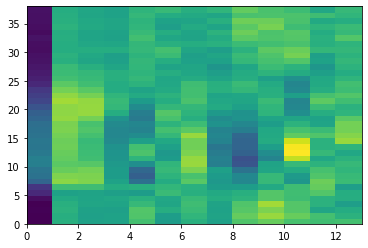

In [114]:
plt.pcolormesh(lmfs.cpu()[0])

tensor(True, device='cuda:0')

In [ ]:
def train(model, epoch, log_interval):
    """  desc: feed training data into model, perform backward pass and optimization steps """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        ipd.clear_output()

        # move data to device (device = GPU if available)
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()  # explicitly set gradients to zero before starting backpropragation
        loss.backward()  # compute gradients
        optimizer.step()  # optimization step: update of parameters

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        # update progress bar
        pbar.update(pbar_update)  # pbar comes from tqdm, defined later
        
        # record loss
        losses.append(loss.item())

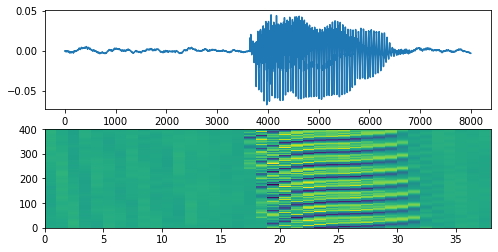

In [4]:
data, sr, *_ = train_set[9000]
waveform, lmfs, lmfcc = data
display(ipd.Audio(waveform.numpy(), rate=sr))
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
axs[0].plot(waveform.t().numpy());
axs[1].pcolormesh(enframe(waveform).T);